# Energy resolution after  delta-z effect correction

## DEMO Run7, esmeralda: 8757, 8758, 8759 @gpu1next


### Nov 2020, JAH

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy             as np
import pandas            as pd
import tables            as tb
import matplotlib.pyplot as plt

to_df = pd.DataFrame.from_records

In [13]:
import hipy.utils        as ut
import hipy.pltext       as pltext

import next.core.io        as nio
import next.core.selection as nsel

import next.eres.eres      as eres

In [14]:
pltext.style()

import warnings
warnings.filterwarnings('ignore')

import time
print(' Last revision ', time.asctime())

 Last revision  Wed Apr 14 09:51:57 2021


### load data

In [15]:
def get_filename(run_number):
    datadir    = f"/home/jrenner/analysis/DEMO/run7/"
    run_number = str(run_number)
    filename   = datadir + f'/cdst_combined_{run_number}' + '.h5'
    return filename

In [6]:
runs      = [8757, 8758, 8759]
filenames = [get_filename(run) for run in runs]
dfts      = [nio.get_dfesme(fname) for fname in filenames]
dft       = pd.concat(dfts)

In [7]:
dft       = pd.concat(dfts)
len(dft)

3080650

### Inspect DF

In [16]:
columns = list(dft.columns)
print(columns)
#pltext.df_inspect(dft, columns[:-1], ncolumns = 3)

['event', 'trackID', 'energy', 'length', 'numb_of_voxels', 'numb_of_hits', 'numb_of_tracks', 'x_min', 'y_min', 'z_min', 'r_min', 'x_max', 'y_max', 'z_max', 'r_max', 'x_ave', 'y_ave', 'z_ave', 'r_ave', 'extreme1_x', 'extreme1_y', 'extreme1_z', 'extreme2_x', 'extreme2_y', 'extreme2_z', 'blob1_x', 'blob1_y', 'blob1_z', 'blob2_x', 'blob2_y', 'blob2_z', 'eblob1', 'eblob2', 'ovlp_blob_energy', 'dz_track', 'enecor', 'time', 'nS2', 'S1e', 'S2e', 'S2q', 'Nsipm', 'evt_energy', 'evt_ntrks', 'evt_nhits', 'evt_out_of_map']


### selections and ranges

In [17]:
ranges = {'nS2'            : (1., 1.),
          'evt_out_of_map' : (False, False),
          'numb_of_tracks' : (1., 1.),
          'z_min'          : (15., 300.),
          'z_max'          : (15., 300.),
          'r_max'          : (0.,  55.),
          'energy'         : (0., 3.),
          'energy.cs'      : (0.65, 0.75),
          'energy.ds'      : (1.60, 1.85),
          'energy.ph'      : (2.00, 3.00),
         }
for key in ranges.keys():
    print(key, ranges[key])

nS2 (1.0, 1.0)
evt_out_of_map (False, False)
numb_of_tracks (1.0, 1.0)
z_min (15.0, 300.0)
z_max (15.0, 300.0)
r_max (0.0, 55.0)
energy (0.0, 3.0)
energy.cs (0.65, 0.75)
energy.ds (1.6, 1.85)
energy.ph (2.0, 3.0)


In [10]:
selections = nsel.Selections(dft, ranges)

            names        eff      ueff
0             nS2  27.062893  0.025313
1  numb_of_tracks  24.683168  0.024565
2           z_min  22.251505  0.023698
3           z_max  20.626426  0.023053
4           r_max   3.185237  0.010005


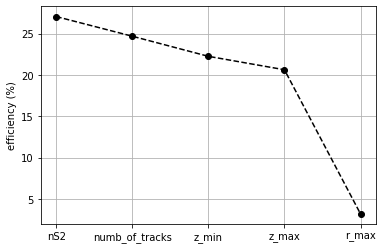

In [18]:
selnames    = ('nS2', 'numb_of_tracks', 'z_min', 'z_max', 'r_max') 
sels        = [selections[selname] for selname in selnames]
effs, ueffs = eres.efficiencies(sels, selnames, True)
df = pd.DataFrame({'names' : selnames, 'eff' : effs, 'ueff' : ueffs})
print(df)

In [19]:
selnames    = ('nS2', 'numb_of_tracks', 'z_min', 'z_max', 'r_max')
selections.logical_and(selnames, 'fidutial');

In [116]:
#pltext.df_inspect(dft[selections['fidutial']], columns[:-1], ncolumns = 3)

### Energy 

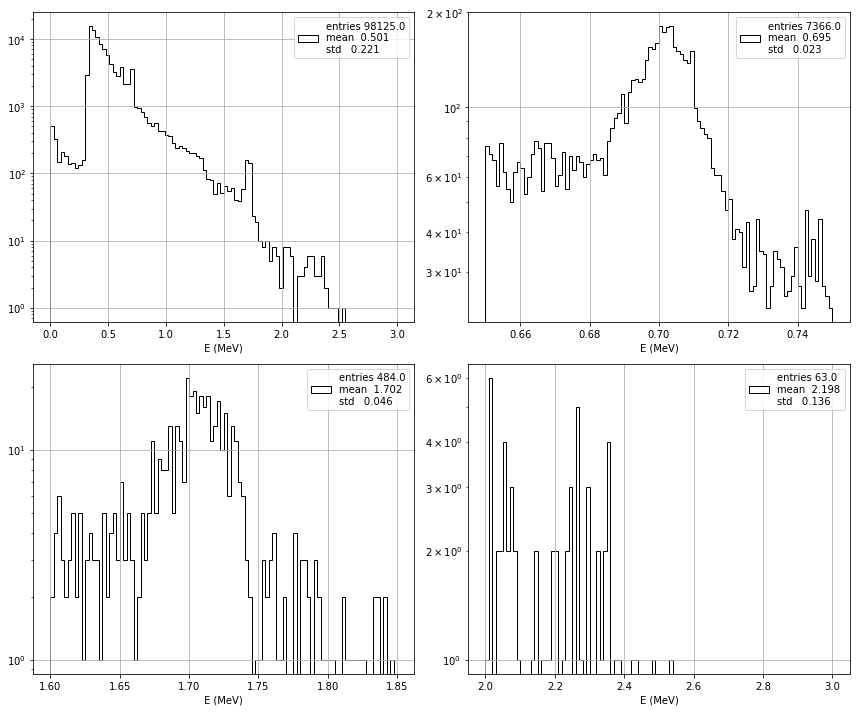

In [20]:
def plt_energies(enes, ranges, bins = 100):

    nplots = len(ranges)

    subplot = pltext.canvas(nplots, 2)
    
    for i in range(nplots):
        subplot( i + 1)
        pltext.hist(enes, bins, range = ranges[i], ylog = True, xylabels = 'E (MeV)'); 
    plt.tight_layout()

sel     = selections['fidutial']
eranges = [ranges[name] for name in ('energy', 'energy.cs', 'energy.ds', 'energy.ph')]
plt_energies(dft.energy[sel], eranges)
#plt_energies(dft.energy)

(0.7015182729072909, 0.008275287722303107, 0.00025920699098702844, 2.772119686465004, 0.08683115641379982)


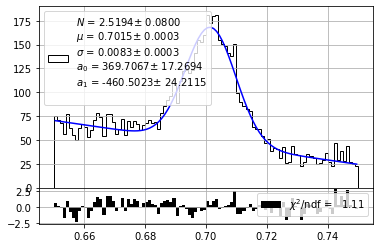

In [21]:
bins   = 100
sel    = selections['fidutial']
enes   = dft.energy[sel].values
erange = ranges['energy.cs']
pars = eres.energy_fit(enes, bins, range = erange, plot = True);
print(pars)

(1.7088031666344816, 0.017556557112037997, 0.0016610434010510815, 2.4144330967356225, 0.2284319264317587)


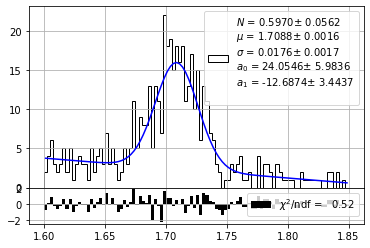

In [22]:
sel    = selections['fidutial']
enes   = dft.energy[sel].values
erange = ranges['energy.ds']
pars = eres.energy_fit(enes, bins, range = erange, plot = True);
print(pars)

## Delta Z- Effect

## Cs

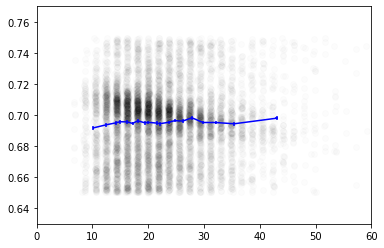

In [24]:
sel   = selections['fidutial'] & selections['energy.cs']
bins = 20

dz, ene = [dft[name][sel].values for name in ('dz_track', 'energy')]
plt.scatter(dz, ene,alpha = 0.01); plt.xlim((0., 60.));
pltext.hprofile(dz, ene, bins = bins, xrange = (0., 60), percentile = True, color = 'blue');

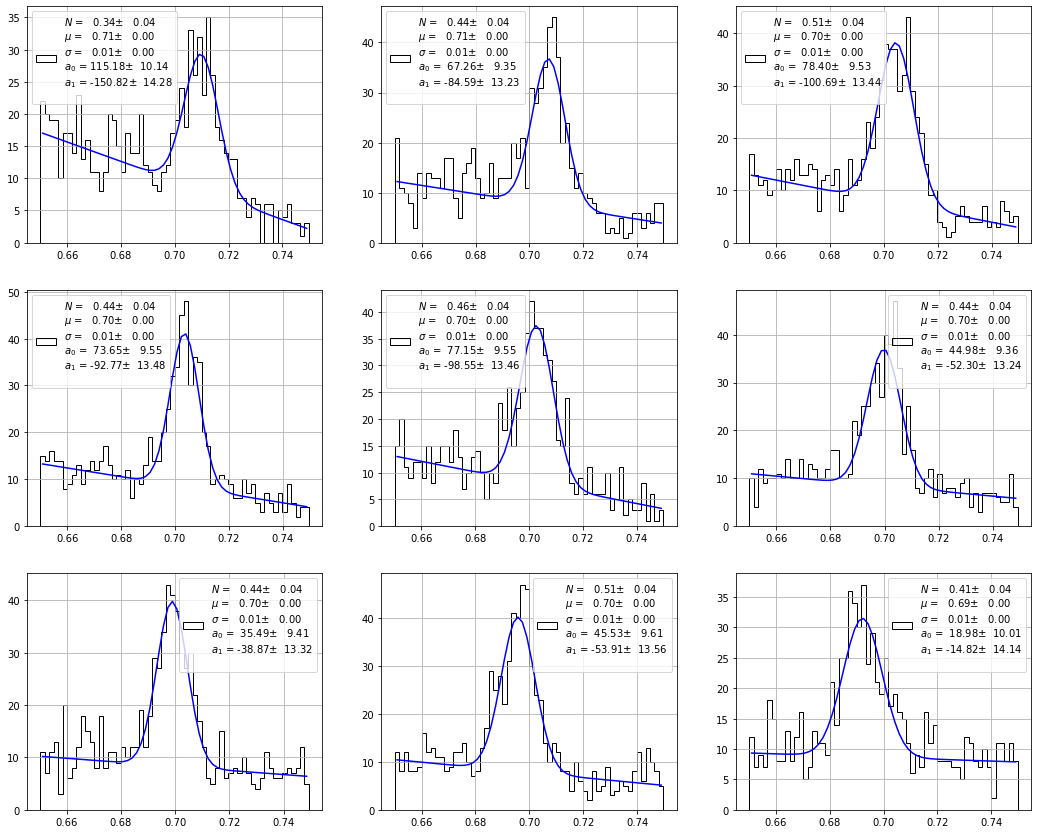

In [25]:
nbins = 10
p0s   = 10*[None,]
p0s[0] = (10., 0.71, 0.02, 70., -70)
xmed, mus, sigs = eres.dz_effect_profile(dz, ene, nbins, p0s = p0s, plot = True);

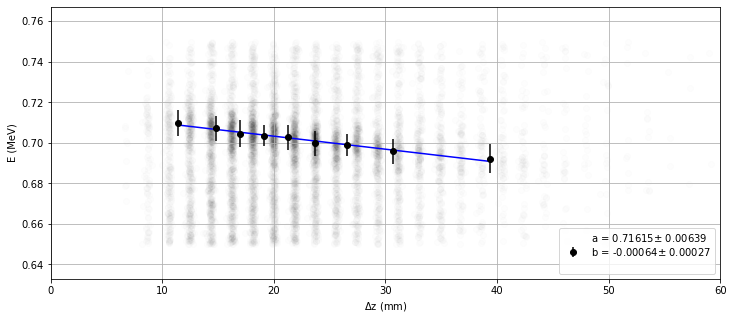

In [41]:
pltext.canvas(1);
plt.scatter(dz, ene, alpha = 0.007); plt.xlim((0., 60.));
par, upars = eres.dz_effect(xmed, mus, sigs, plot = True);
plt.xlabel(r'$\Delta$z (mm)'); plt.ylabel('E (MeV)');

### Double Scape

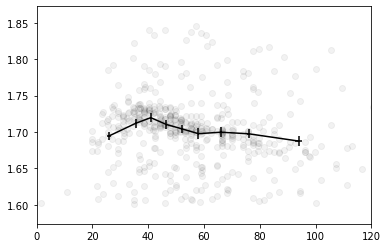

In [43]:
sel   = selections['fidutial'] & selections['energy.ds']
bins = 10

dz, ene = [dft[name][sel].values for name in ('dz_track', 'energy')]
plt.scatter(dz, ene,alpha = 0.05); plt.xlim((0., 120.));
pltext.hprofile(dz, ene, bins = bins, xrange = (0., 120), percentile = True);

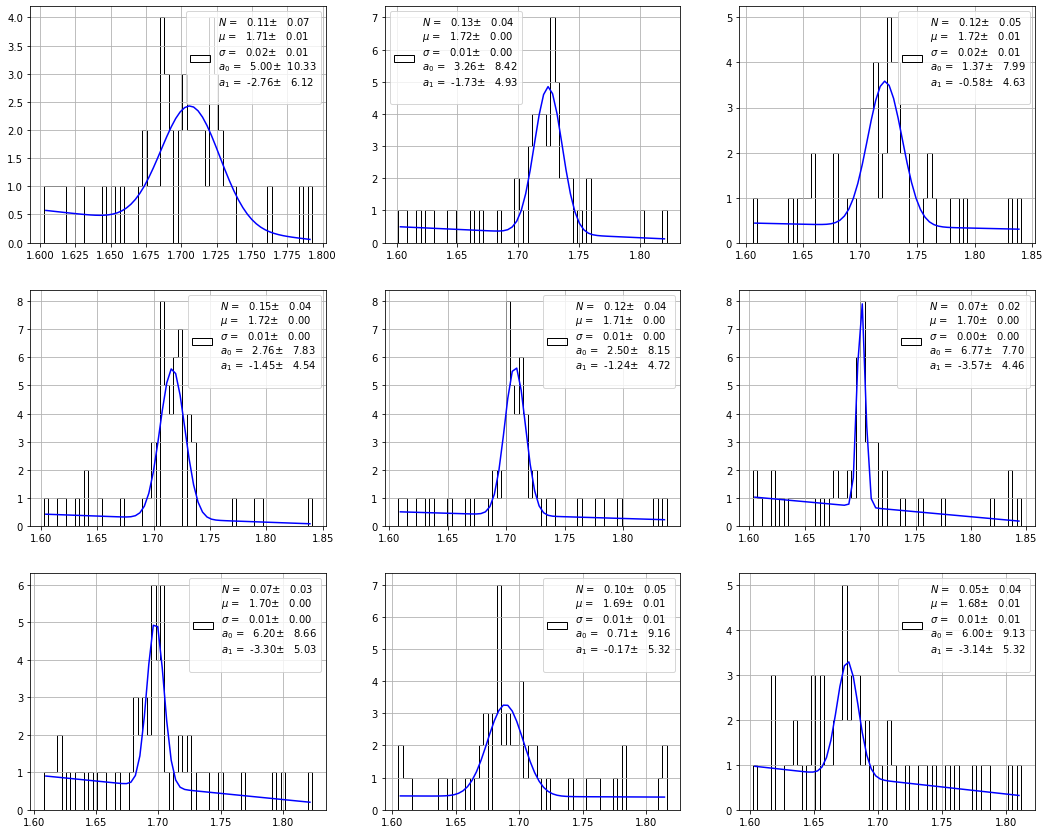

In [44]:
nbins = 10
p0s   = 10*[None,]
xmed, mus, sigs = eres.dz_effect_profile(dz, ene, nbins, p0s = p0s, plot = True);

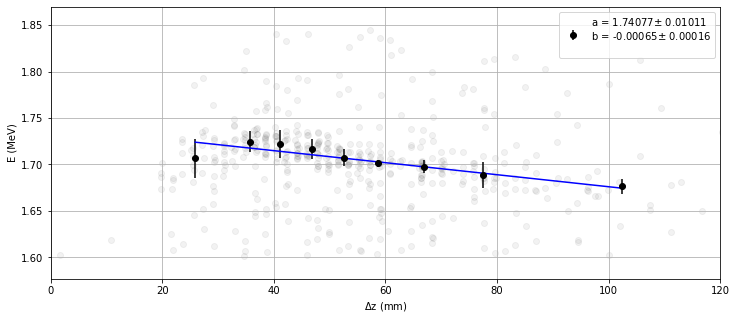

In [47]:
pltext.canvas(1);
plt.scatter(dz, ene, alpha = 0.05); plt.xlim((0., 120.));
par, upars = eres.dz_effect(xmed, mus, sigs, plot = True);
plt.xlabel(r'$\Delta$z (mm)'); plt.ylabel('E (MeV)');